In [37]:
import pandas as pd
import numpy as np
from pathlib import Path
import datetime as dt
import re
from geopy.distance import vincenty
import matplotlib.dates as mdts
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from sklearn.svm import LinearSVC, SVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import confusion_matrix, f1_score, make_scorer, roc_curve, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from time import time
from tsfresh import extract_relevant_features, extract_features
import xgboost as xgb

/opt/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [107]:
accdnt_windows = pd.read_csv('../data/PeMS/Incidents/work_folder/year_accdnt_wndw.csv', parse_dates=['Timestamp'])

In [108]:
accdnt_windows['y'] = 1

In [109]:
accdnt_free_windows = pd.read_csv('../data/PeMS/Incidents/work_folder/year_accdnt_free_wndw.csv', parse_dates=['Timestamp'])
# accdnt_free_windows['IncidentID'] = 0

In [110]:
accdnt_free_windows['y'] = 0

In [224]:
def plot_window(data, chrct = 'Total Flow'):
    
#     cols = [col for col in data.columns if chrct in col]
    cols = [col for col in data.index if chrct in col]
    data[cols].plot()
    plt.grid()
    plt.show()

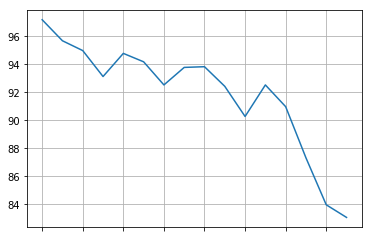

In [225]:
plot_window(accdnt_free_windows.iloc[86])

In [111]:
common_cols = ['Timestamp', 'IncidentID', 'Latitude', 'Longitude', 'Avg Occupancy_0', 'Avg Occupancy_1', 'Avg Occupancy_2',
       'Avg Occupancy_3', 'Avg Occupancy_4', 'Avg Occupancy_5',
       'Avg Occupancy_6', 'Avg Occupancy_7', 'Avg Occupancy_8',
       'Avg Occupancy_9', 'Avg Occupancy_10', 'Avg Occupancy_11',
       'Avg Occupancy_12', 'Avg Occupancy_13', 'Avg Occupancy_14',
       'Avg Occupancy_15', 'Avg Speed_0', 'Avg Speed_1', 'Avg Speed_2',
       'Avg Speed_3', 'Avg Speed_4', 'Avg Speed_5', 'Avg Speed_6',
       'Avg Speed_7', 'Avg Speed_8', 'Avg Speed_9', 'Avg Speed_10',
       'Avg Speed_11', 'Avg Speed_12', 'Avg Speed_13', 'Avg Speed_14',
       'Avg Speed_15', 'Total Flow_0', 'Total Flow_1', 'Total Flow_2',
       'Total Flow_3', 'Total Flow_4', 'Total Flow_5', 'Total Flow_6',
       'Total Flow_7', 'Total Flow_8', 'Total Flow_9', 'Total Flow_10',
       'Total Flow_11', 'Total Flow_12', 'Total Flow_13', 'Total Flow_14',
       'Total Flow_15', 'y',

        'Next_Avg Occupancy_0', 'Next_Avg Occupancy_1', 'Next_Avg Occupancy_2', 'Next_Avg Occupancy_3',
         'Next_Avg Occupancy_4', 'Next_Avg Occupancy_5', 'Next_Avg Occupancy_6', 'Next_Avg Occupancy_7',
         'Next_Avg Occupancy_8', 'Next_Avg Occupancy_9', 'Next_Avg Occupancy_10', 'Next_Avg Occupancy_11',
         'Next_Avg Occupancy_12', 'Next_Avg Occupancy_13', 'Next_Avg Occupancy_14', 'Next_Avg Occupancy_15',
         'Next_Total Flow_0', 'Next_Total Flow_1', 'Next_Total Flow_2', 'Next_Total Flow_3', 'Next_Total Flow_4',
         'Next_Total Flow_5', 'Next_Total Flow_6', 'Next_Total Flow_7', 'Next_Total Flow_8', 'Next_Total Flow_9',
         'Next_Total Flow_10', 'Next_Total Flow_11', 'Next_Total Flow_12', 'Next_Total Flow_13', 'Next_Total Flow_14',
         'Next_Total Flow_15', 'Next_Avg Speed_0', 'Next_Avg Speed_1', 'Next_Avg Speed_2', 'Next_Avg Speed_3',
         'Next_Avg Speed_4', 'Next_Avg Speed_5', 'Next_Avg Speed_6', 'Next_Avg Speed_7', 'Next_Avg Speed_8',
         'Next_Avg Speed_9', 'Next_Avg Speed_10', 'Next_Avg Speed_11', 'Next_Avg Speed_12', 'Next_Avg Speed_13',
         'Next_Avg Speed_14', 'Next_Avg Speed_15',
               ]

In [97]:
dataset[dataset.y==1].shape[0]/dataset.shape[0]

0.4758696260374895

In [96]:
dataset[dataset.y==1].shape[0]

20411

In [112]:
dataset = pd.concat((accdnt_windows[common_cols], accdnt_free_windows[common_cols]), axis=0).reset_index(drop=True)

In [87]:
weather = pd.read_csv('../data/Weather/weather.csv', parse_dates=["Date"])

In [88]:
weather['Date'] = weather.Date.dt.date

In [89]:
dataset['Date'] = dataset.Timestamp.dt.date

In [90]:
dataset = dataset.merge(weather, how='left', on='Date').drop(columns='Date')

In [113]:
dataset['Hour'] = dataset.Timestamp.dt.hour

In [114]:
dataset = dataset.drop(index=dataset[(dataset['Hour']<6) | (dataset['Hour']>21)].index).reset_index(drop=True)

In [115]:
dataset = pd.get_dummies(dataset, columns=['Hour'], prefix='hour')

In [116]:
np.random.seed(442)
dataset = dataset.loc[np.random.choice(dataset.shape[0], dataset.shape[0], replace=False)]

In [117]:
dataset.reset_index(drop=True, inplace=True)

In [127]:
non_series_cols = [col for col in dataset.columns if 'Avg' not in col and 'Total' not in col]

In [32]:
dataset.to_csv('../data/PeMS/Incidents/work_folder/windows.csv', index=False)

In [246]:
dataset= pd.read_csv('../data/PeMS/Incidents/work_folder/fst_dataset/windows.csv', parse_dates=['Timestamp'])

In [12]:
def feature_extraction(dataset):
    cols = [col for col in dataset.columns if 'Avg' in col or 'Total' in col]
    dataset = dataset[cols]
    t_labels = np.arange(len(cols)/3, dtype=int)
    t_labels = np.concatenate((t_labels,t_labels,t_labels))
    aux_labels = pd.DataFrame({'val_name': cols, 't': t_labels})
    long = dataset.reset_index().melt(id_vars=['index'], var_name='series_param', value_name='value')
    long = long.merge(aux_labels, how='left', left_on='series_param', right_on='val_name').drop('val_name', axis=1)
    long['series_param'] = long['series_param'].apply(lambda row: row.split('_')[0])
    long = long.rename(columns={'index': 'ID'})[['ID', 't', 'series_param', 'value']]
    extracted = extract_features(long, column_id='ID', column_sort='t', column_kind='series_param', column_value='value', n_jobs=4)
    # try imputation
    extracted.dropna(axis=1, how='any', inplace=True)
    return extracted

In [13]:
def batch_extraction(dataset, b_size):
    m=dataset.shape[0]
    result=pd.DataFrame()
    for i in range(0, m, b_size):
        crnt_ftrs = feature_extraction(dataset.loc[i:i+b_size-1])
#         result = pd.concat((result, crnt_ftrs))
        crnt_ftrs.to_csv('../data/PeMS/Incidents/work_folder/extracted/extracted_{0:d}.csv'.format(i), index=False)
    print('EGOR virubajjj!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!')


In [14]:
rnm_cols = ['Avg Occupancy_0', 'Avg Occupancy_1', 'Avg Occupancy_2',
       'Avg Occupancy_3', 'Avg Occupancy_4', 'Avg Occupancy_5',
       'Avg Occupancy_6', 'Avg Occupancy_7', 'Avg Occupancy_8',
       'Avg Occupancy_9', 'Avg Occupancy_10', 'Avg Occupancy_11',
       'Avg Occupancy_12', 'Avg Occupancy_13', 'Avg Occupancy_14',
       'Avg Occupancy_15', 'Avg Speed_0', 'Avg Speed_1', 'Avg Speed_2',
       'Avg Speed_3', 'Avg Speed_4', 'Avg Speed_5', 'Avg Speed_6',
       'Avg Speed_7', 'Avg Speed_8', 'Avg Speed_9', 'Avg Speed_10',
       'Avg Speed_11', 'Avg Speed_12', 'Avg Speed_13', 'Avg Speed_14',
       'Avg Speed_15', 'Total Flow_0', 'Total Flow_1', 'Total Flow_2',
       'Total Flow_3', 'Total Flow_4', 'Total Flow_5', 'Total Flow_6',
       'Total Flow_7', 'Total Flow_8', 'Total Flow_9', 'Total Flow_10',
       'Total Flow_11', 'Total Flow_12', 'Total Flow_13', 'Total Flow_14',
       'Total Flow_15']

In [15]:
dct = dict()
for col in rnm_cols:
    dct['Next_'+col] = 'Next '+col

In [16]:
dataset.rename(columns=dct, inplace=True)

In [18]:
batch_extraction(dataset, 1000)

Feature Extraction: 100%|██████████| 20/20 [03:16<00:00,  9.81s/it]


FileNotFoundError: [Errno 2] No such file or directory: '../data/PeMS/Incidents/work_folder/extracted/extracted_0.csv'

In [129]:
tr_X, te_X, tr_y, te_y = train_test_split(test.drop(columns=['y']), test['y'], stratify=test.y, test_size=.2)

In [236]:
logreg = LogisticRegression()
logreg.fit(tr_X, tr_y)
print('acc =', logreg.score(te_X, te_y))
predict = logreg.predict(te_X)
F1_score = f1_score(te_y, predict)
print('f1 =', F1_score)
print('CM =', confusion_matrix(te_y, predict))

acc = 0.6635275652344517
f1 = 0.6567940764458675
CM = [[3482 1431]
 [1999 3282]]


In [237]:
forest = RandomForestClassifier(random_state=14)
forest.fit(tr_X, tr_y)
print('acc =', forest.score(te_X, te_y))
predict = forest.predict(te_X)
F1_score = f1_score(te_y, predict)
print('f1 =', F1_score)
print('CM =', confusion_matrix(te_y, predict, labels=[0,1]))

acc = 0.7032568177359231
f1 = 0.6977720051953242
CM = [[3677 1236]
 [1789 3492]]


In [238]:
proba = forest.predict_proba(te_X)

In [239]:
fpr, tpr, _ = roc_curve(te_y, proba[:,1])

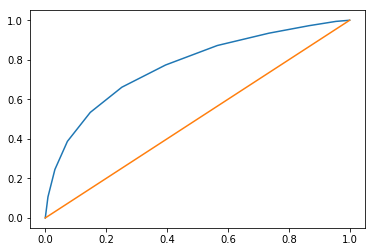

In [240]:
plt.plot(fpr, tpr)
plt.plot([0, 1],[0,1])
plt.show()

In [15]:
def batch_concatenation(dataset, b_size):
    m=dataset.shape[0]
    result = pd.DataFrame()
    for i in range(0, m, b_size):
        crnt_ftrs = pd.read_csv('../data/PeMS/Incidents/work_folder/fst_dataset/extracted/extracted_{0:d}.csv'.format(i))
        crnt_ftrs = crnt_ftrs.replace([np.inf, -np.inf], np.NaN)
        crnt_ftrs.dropna(axis=1, inplace=True)
        result = pd.concat((result, crnt_ftrs), axis=0)
    result = result.dropna(axis=1).reset_index(drop=True)
    non_series_cols = [col for col in dataset.columns if 'Avg' not in col and 'Total' not in col]
    result = pd.concat((result, dataset[non_series_cols]), axis=1)
    return result

In [16]:
test = batch_concatenation(dataset,1000)

In [17]:
test.drop(columns='Timestamp', inplace=True)

In [18]:
test.to_csv('../data/PeMS/Incidents/work_folder/fst_dataset/extracted.csv', index=False)

In [2]:
test = pd.read_csv('../data/PeMS/Incidents/work_folder/fst_dataset/extracted.csv')

In [19]:
tr_X, te_X, tr_y, te_y = train_test_split(test.drop(columns=['y', 'IncidentID']), test['y'], stratify=test.y)

In [20]:
scaler = StandardScaler()

In [21]:
tr_X = scaler.fit_transform(tr_X)

In [22]:
te_X = scaler.transform(te_X)

In [29]:
logreg = LogisticRegression()
logreg.fit(tr_X, tr_y)
print('acc =', logreg.score(te_X, te_y))
predict = logreg.predict(te_X)
F1_score = f1_score(te_y, predict)
print('f1 =', F1_score)
print('CM =', confusion_matrix(te_y, predict))

acc = 0.6731410633706102
f1 = 0.6624797406807131
CM = [[3592 1321]
 [2011 3270]]


In [30]:
forest = RandomForestClassifier(random_state=14)
forest.fit(tr_X, tr_y)
print('acc =', forest.score(te_X, te_y))
predict = forest.predict(te_X)
F1_score = f1_score(te_y, predict)
print('f1 =', F1_score)
print('CM =', confusion_matrix(te_y, predict, labels=[0,1]))

acc = 0.6783402001177163
f1 = 0.6674104878790952
CM = [[3625 1288]
 [1991 3290]]


In [145]:
grid_params = {'n_estimators': [10, 100, 200],
               'max_depth' : [2, 3, 5],  
               'min_samples_leaf': [2, 5, 10]
}
grd_search = GridSearchCV(forest, grid_params,
                          scoring={'f1_score' : make_scorer(f1_score)},
                          refit='f1_score',
                          cv=5, return_train_score=True, n_jobs=-1, verbose=2)

In [264]:
grd_search.fit(tr_X, tr_y)

Fitting 5 folds for each of 27 candidates, totalling 135 fits
[CV] max_depth=2, min_samples_leaf=2, n_estimators=10 ................
[CV] max_depth=2, min_samples_leaf=2, n_estimators=10 ................
[CV] max_depth=2, min_samples_leaf=2, n_estimators=10 ................
[CV] max_depth=2, min_samples_leaf=2, n_estimators=10 ................
[CV] . max_depth=2, min_samples_leaf=2, n_estimators=10, total=   3.1s
[CV] max_depth=2, min_samples_leaf=2, n_estimators=10 ................
[CV] . max_depth=2, min_samples_leaf=2, n_estimators=10, total=   3.0s
[CV] . max_depth=2, min_samples_leaf=2, n_estimators=10, total=   3.0s
[CV] . max_depth=2, min_samples_leaf=2, n_estimators=10, total=   3.1s
[CV] max_depth=2, min_samples_leaf=2, n_estimators=100 ...............
[CV] max_depth=2, min_samples_leaf=2, n_estimators=100 ...............
[CV] max_depth=2, min_samples_leaf=2, n_estimators=100 ...............
[CV] . max_depth=2, min_samples_leaf=2, n_estimators=10, total=   0.4s
[CV] max_depth=

[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   31.3s


[CV]  max_depth=2, min_samples_leaf=5, n_estimators=200, total=   6.7s
[CV] max_depth=2, min_samples_leaf=10, n_estimators=100 ..............
[CV]  max_depth=2, min_samples_leaf=10, n_estimators=100, total=   3.6s
[CV] max_depth=2, min_samples_leaf=10, n_estimators=100 ..............
[CV]  max_depth=2, min_samples_leaf=10, n_estimators=100, total=   3.7s
[CV] max_depth=2, min_samples_leaf=10, n_estimators=100 ..............
[CV]  max_depth=2, min_samples_leaf=10, n_estimators=100, total=   3.9s
[CV] max_depth=2, min_samples_leaf=10, n_estimators=200 ..............
[CV]  max_depth=2, min_samples_leaf=5, n_estimators=200, total=   7.0s
[CV] max_depth=2, min_samples_leaf=10, n_estimators=200 ..............
[CV]  max_depth=2, min_samples_leaf=10, n_estimators=100, total=   3.1s
[CV] max_depth=2, min_samples_leaf=10, n_estimators=200 ..............
[CV]  max_depth=2, min_samples_leaf=10, n_estimators=100, total=   3.3s
[CV] max_depth=2, min_samples_leaf=10, n_estimators=200 ..............
[

[Parallel(n_jobs=-1)]: Done 135 out of 135 | elapsed:  3.0min finished


GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=14, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'n_estimators': [10, 100, 200], 'max_depth': [2, 3, 5], 'min_samples_leaf': [2, 5, 10]},
       pre_dispatch='2*n_jobs', refit='f1_score', return_train_score=True,
       scoring={'f1_score': make_scorer(f1_score)}, verbose=2)

In [265]:
grd_search.best_score_

0.5738945649022463

In [186]:
for col in dataset.columns:
    print(col)

IncidentID
Latitude
Longitude
Avg Occupancy_0
Avg Occupancy_1
Avg Occupancy_2
Avg Occupancy_3
Avg Occupancy_4
Avg Occupancy_5
Avg Occupancy_6
Avg Occupancy_7
Avg Occupancy_8
Avg Occupancy_9
Avg Occupancy_10
Avg Occupancy_11
Avg Occupancy_12
Avg Occupancy_13
Avg Occupancy_14
Avg Occupancy_15
Avg Speed_0
Avg Speed_1
Avg Speed_2
Avg Speed_3
Avg Speed_4
Avg Speed_5
Avg Speed_6
Avg Speed_7
Avg Speed_8
Avg Speed_9
Avg Speed_10
Avg Speed_11
Avg Speed_12
Avg Speed_13
Avg Speed_14
Avg Speed_15
Total Flow_0
Total Flow_1
Total Flow_2
Total Flow_3
Total Flow_4
Total Flow_5
Total Flow_6
Total Flow_7
Total Flow_8
Total Flow_9
Total Flow_10
Total Flow_11
Total Flow_12
Total Flow_13
Total Flow_14
Total Flow_15
y
hour__6
hour__7
hour__8
hour__9
hour__10
hour__11
hour__12
hour__13
hour__14
hour__15
hour__16
hour__17
hour__18
hour__19
hour__20
hour__21
Avg Occupancy_0_sq
Avg Occupancy_1_sq
Avg Occupancy_2_sq
Avg Occupancy_3_sq
Avg Occupancy_4_sq
Avg Occupancy_5_sq
Avg Occupancy_6_sq
Avg Occupancy_7_sq
Av

In [70]:
def score_dataset(dataset, drop_features=[], cv=5):
    drop_cols = ['y', 'Timestamp', 'IncidentID'] + drop_features #, 'Longitude', 'Latitude'
    tr_X, te_X, tr_y, te_y = train_test_split(dataset.drop(columns=drop_cols), dataset['y'], stratify=dataset.y, test_size=.2)
    scaler = StandardScaler()
    tr_X = scaler.fit_transform(tr_X)
    te_X = scaler.transform(te_X)
        
    print('Logistic regression')
    logreg = LogisticRegression()
    cv_res = cross_validate(logreg, tr_X, tr_y, n_jobs=-1, cv=cv, scoring={'f1_score' : make_scorer(f1_score)})
    F1_score = cv_res['test_f1_score'].mean()
    F1_var = cv_res['test_f1_score'].std()
    print('{}-fold CV f1 = {}, std = {}'.format(cv, F1_score, F1_var))
    logreg.fit(tr_X, tr_y)
    predict = logreg.predict(te_X)
    print('example CM =', confusion_matrix(te_y, predict))
    print()
    
    print('Random Forest')
    forest = RandomForestClassifier(random_state=14)  
    cv_res = cross_validate(forest, tr_X, tr_y, n_jobs=-1, cv=cv, scoring={'f1_score' : make_scorer(f1_score)})
    F1_score = cv_res['test_f1_score'].mean()
    F1_var = cv_res['test_f1_score'].std()
    print('{}-fold CV f1 = {}, std = {}'.format(cv, F1_score, F1_var))
    forest.fit(tr_X, tr_y)
    predict = forest.predict(te_X)
    proba = forest.predict_proba(te_X)
    print('example CM =', confusion_matrix(te_y, predict))
    fpr, tpr, thresholds = roc_curve(te_y, proba[:,1])
    
    plt.plot(fpr, tpr)
    plt.plot([0,1], [0,1])
    plt.grid()
    plt.show()
    
    print()
    


Logistic regression
5-fold CV f1 = 0.6487233026700397, std = 0.004591180431084991
example CM = [[2761 1169]
 [1725 2500]]

Random Forest
5-fold CV f1 = 0.6616747379640213, std = 0.005658515948329251
example CM = [[2860 1070]
 [1588 2637]]


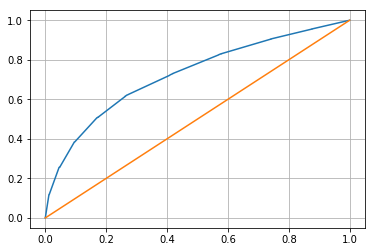

In [22]:
score_dataset(dataset)

# W/o weather data

## as is

Logistic regression
5-fold CV f1 = 0.6204714855330495, std = 0.0034408794852207446
example CM = [[3540  957]
 [1773 2309]]

Random Forest
5-fold CV f1 = 0.6515166630630926, std = 0.005577138040868198
example CM = [[3604  893]
 [1558 2524]]


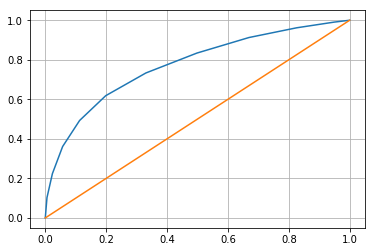

In [71]:
score_dataset(dataset)

## w/o Next

In [72]:
Next_cols = ['Next_Avg Occupancy_0', 'Next_Avg Occupancy_1', 'Next_Avg Occupancy_2', 'Next_Avg Occupancy_3',
         'Next_Avg Occupancy_4', 'Next_Avg Occupancy_5', 'Next_Avg Occupancy_6', 'Next_Avg Occupancy_7',
         'Next_Avg Occupancy_8', 'Next_Avg Occupancy_9', 'Next_Avg Occupancy_10', 'Next_Avg Occupancy_11',
         'Next_Avg Occupancy_12', 'Next_Avg Occupancy_13', 'Next_Avg Occupancy_14', 'Next_Avg Occupancy_15',
         'Next_Total Flow_0', 'Next_Total Flow_1', 'Next_Total Flow_2', 'Next_Total Flow_3', 'Next_Total Flow_4',
         'Next_Total Flow_5', 'Next_Total Flow_6', 'Next_Total Flow_7', 'Next_Total Flow_8', 'Next_Total Flow_9',
         'Next_Total Flow_10', 'Next_Total Flow_11', 'Next_Total Flow_12', 'Next_Total Flow_13', 'Next_Total Flow_14',
         'Next_Total Flow_15', 'Next_Avg Speed_0', 'Next_Avg Speed_1', 'Next_Avg Speed_2', 'Next_Avg Speed_3',
         'Next_Avg Speed_4', 'Next_Avg Speed_5', 'Next_Avg Speed_6', 'Next_Avg Speed_7', 'Next_Avg Speed_8',
         'Next_Avg Speed_9', 'Next_Avg Speed_10', 'Next_Avg Speed_11', 'Next_Avg Speed_12', 'Next_Avg Speed_13',
         'Next_Avg Speed_14', 'Next_Avg Speed_15',]

Logistic regression
5-fold CV f1 = 0.6076463929700565, std = 0.008169215220721622
example CM = [[3554  943]
 [1921 2161]]

Random Forest
5-fold CV f1 = 0.6461133390321494, std = 0.005215437418034422
example CM = [[3575  922]
 [1621 2461]]


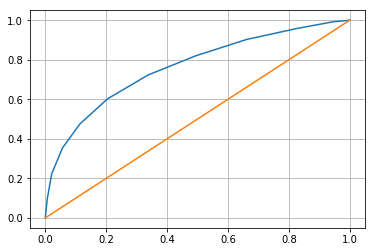

In [73]:
score_dataset(dataset, Next_cols)

## delta

In [74]:
for col in ['Avg Occupancy_0', 'Avg Occupancy_1', 'Avg Occupancy_2',
       'Avg Occupancy_3', 'Avg Occupancy_4', 'Avg Occupancy_5',
       'Avg Occupancy_6', 'Avg Occupancy_7', 'Avg Occupancy_8',
       'Avg Occupancy_9', 'Avg Occupancy_10', 'Avg Occupancy_11',
       'Avg Occupancy_12', 'Avg Occupancy_13', 'Avg Occupancy_14',
       'Avg Occupancy_15', 'Avg Speed_0', 'Avg Speed_1', 'Avg Speed_2',
       'Avg Speed_3', 'Avg Speed_4', 'Avg Speed_5', 'Avg Speed_6',
       'Avg Speed_7', 'Avg Speed_8', 'Avg Speed_9', 'Avg Speed_10',
       'Avg Speed_11', 'Avg Speed_12', 'Avg Speed_13', 'Avg Speed_14',
       'Avg Speed_15', 'Total Flow_0', 'Total Flow_1', 'Total Flow_2',
       'Total Flow_3', 'Total Flow_4', 'Total Flow_5', 'Total Flow_6',
       'Total Flow_7', 'Total Flow_8', 'Total Flow_9', 'Total Flow_10',
       'Total Flow_11', 'Total Flow_12', 'Total Flow_13', 'Total Flow_14',
       'Total Flow_15']:
    dataset[col] = dataset[col] - dataset['Next_'+col]
    dataset[col + '_sq'] = (dataset[col] - dataset['Next_'+col] )**2
    dataset.drop(columns='Next_'+col, inplace=True)

In [75]:
sq_cols = [col for col in dataset.columns if '_sq' in col]

Logistic regression
5-fold CV f1 = 0.5572119682258452, std = 0.005164806167936775
example CM = [[3003 1494]
 [1964 2118]]

Random Forest
5-fold CV f1 = 0.641371017011141, std = 0.005067828607036853
example CM = [[3483 1014]
 [1629 2453]]


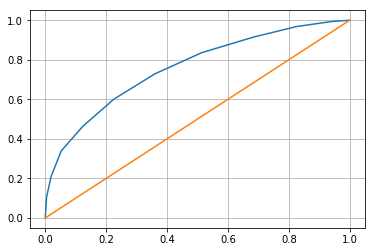

In [76]:
score_dataset(dataset, sq_cols)

## diff and sq diff

Logistic regression
5-fold CV f1 = 0.5992830994965688, std = 0.00744571707889029
example CM = [[3515  982]
 [1931 2151]]

Random Forest
5-fold CV f1 = 0.6436743262266829, std = 0.010227118953861634
example CM = [[3551  946]
 [1603 2479]]


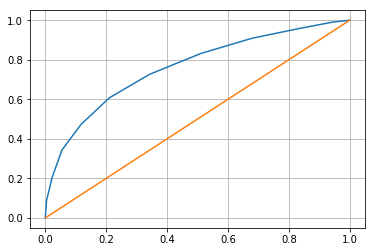

In [77]:
score_dataset(dataset)

# W/ weather data

## as is

Logistic regression
5-fold CV f1 = 0.6255739231213896, std = 0.007125384164661013
example CM = [[3495 1002]
 [1769 2313]]

Random Forest
5-fold CV f1 = 0.6509493346040063, std = 0.0038487137644732943
example CM = [[3585  912]
 [1558 2524]]


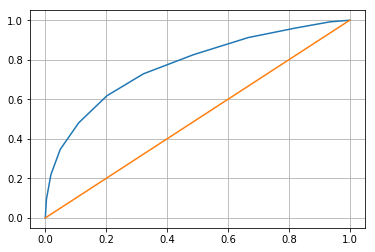

In [98]:
score_dataset(dataset)

## w/o Next

In [99]:
Next_cols = ['Next_Avg Occupancy_0', 'Next_Avg Occupancy_1', 'Next_Avg Occupancy_2', 'Next_Avg Occupancy_3',
         'Next_Avg Occupancy_4', 'Next_Avg Occupancy_5', 'Next_Avg Occupancy_6', 'Next_Avg Occupancy_7',
         'Next_Avg Occupancy_8', 'Next_Avg Occupancy_9', 'Next_Avg Occupancy_10', 'Next_Avg Occupancy_11',
         'Next_Avg Occupancy_12', 'Next_Avg Occupancy_13', 'Next_Avg Occupancy_14', 'Next_Avg Occupancy_15',
         'Next_Total Flow_0', 'Next_Total Flow_1', 'Next_Total Flow_2', 'Next_Total Flow_3', 'Next_Total Flow_4',
         'Next_Total Flow_5', 'Next_Total Flow_6', 'Next_Total Flow_7', 'Next_Total Flow_8', 'Next_Total Flow_9',
         'Next_Total Flow_10', 'Next_Total Flow_11', 'Next_Total Flow_12', 'Next_Total Flow_13', 'Next_Total Flow_14',
         'Next_Total Flow_15', 'Next_Avg Speed_0', 'Next_Avg Speed_1', 'Next_Avg Speed_2', 'Next_Avg Speed_3',
         'Next_Avg Speed_4', 'Next_Avg Speed_5', 'Next_Avg Speed_6', 'Next_Avg Speed_7', 'Next_Avg Speed_8',
         'Next_Avg Speed_9', 'Next_Avg Speed_10', 'Next_Avg Speed_11', 'Next_Avg Speed_12', 'Next_Avg Speed_13',
         'Next_Avg Speed_14', 'Next_Avg Speed_15',]

Logistic regression
5-fold CV f1 = 0.6120812030491221, std = 0.01115767465122743
example CM = [[3501  996]
 [1810 2272]]

Random Forest
5-fold CV f1 = 0.6486535423576457, std = 0.0075746043504348005
example CM = [[3545  952]
 [1592 2490]]


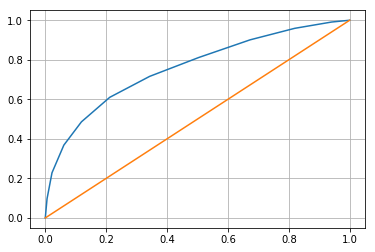

In [100]:
score_dataset(dataset, Next_cols)

## delta

In [101]:
for col in ['Avg Occupancy_0', 'Avg Occupancy_1', 'Avg Occupancy_2',
       'Avg Occupancy_3', 'Avg Occupancy_4', 'Avg Occupancy_5',
       'Avg Occupancy_6', 'Avg Occupancy_7', 'Avg Occupancy_8',
       'Avg Occupancy_9', 'Avg Occupancy_10', 'Avg Occupancy_11',
       'Avg Occupancy_12', 'Avg Occupancy_13', 'Avg Occupancy_14',
       'Avg Occupancy_15', 'Avg Speed_0', 'Avg Speed_1', 'Avg Speed_2',
       'Avg Speed_3', 'Avg Speed_4', 'Avg Speed_5', 'Avg Speed_6',
       'Avg Speed_7', 'Avg Speed_8', 'Avg Speed_9', 'Avg Speed_10',
       'Avg Speed_11', 'Avg Speed_12', 'Avg Speed_13', 'Avg Speed_14',
       'Avg Speed_15', 'Total Flow_0', 'Total Flow_1', 'Total Flow_2',
       'Total Flow_3', 'Total Flow_4', 'Total Flow_5', 'Total Flow_6',
       'Total Flow_7', 'Total Flow_8', 'Total Flow_9', 'Total Flow_10',
       'Total Flow_11', 'Total Flow_12', 'Total Flow_13', 'Total Flow_14',
       'Total Flow_15']:
    dataset[col] = dataset[col] - dataset['Next_'+col]
    dataset[col + '_sq'] = (dataset[col] - dataset['Next_'+col] )**2
    dataset.drop(columns='Next_'+col, inplace=True)

In [102]:
sq_cols = [col for col in dataset.columns if '_sq' in col]

Logistic regression
5-fold CV f1 = 0.5543746535325316, std = 0.0069041568386644814
example CM = [[3104 1393]
 [1971 2111]]

Random Forest
5-fold CV f1 = 0.642122876026546, std = 0.005489915001763578
example CM = [[3557  940]
 [1704 2378]]


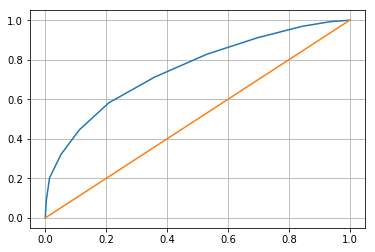

In [103]:
score_dataset(dataset, sq_cols)

## diff and sq diff

Logistic regression
5-fold CV f1 = 0.6037931126407882, std = 0.008550254146928657
example CM = [[3478 1019]
 [1901 2181]]

Random Forest
5-fold CV f1 = 0.6412568259418202, std = 0.010337640986047215
example CM = [[3513  984]
 [1610 2472]]


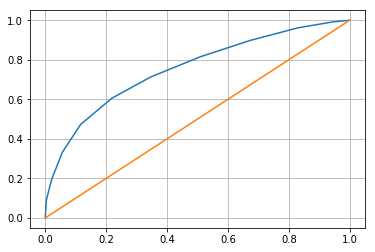

In [104]:
score_dataset(dataset)

In [105]:
non_sq_cols = ['Avg Occupancy_0', 'Avg Occupancy_1', 'Avg Occupancy_2',
       'Avg Occupancy_3', 'Avg Occupancy_4', 'Avg Occupancy_5',
       'Avg Occupancy_6', 'Avg Occupancy_7', 'Avg Occupancy_8',
       'Avg Occupancy_9', 'Avg Occupancy_10', 'Avg Occupancy_11',
       'Avg Occupancy_12', 'Avg Occupancy_13', 'Avg Occupancy_14',
       'Avg Occupancy_15', 'Avg Speed_0', 'Avg Speed_1', 'Avg Speed_2',
       'Avg Speed_3', 'Avg Speed_4', 'Avg Speed_5', 'Avg Speed_6',
       'Avg Speed_7', 'Avg Speed_8', 'Avg Speed_9', 'Avg Speed_10',
       'Avg Speed_11', 'Avg Speed_12', 'Avg Speed_13', 'Avg Speed_14',
       'Avg Speed_15', 'Total Flow_0', 'Total Flow_1', 'Total Flow_2',
       'Total Flow_3', 'Total Flow_4', 'Total Flow_5', 'Total Flow_6',
       'Total Flow_7', 'Total Flow_8', 'Total Flow_9', 'Total Flow_10',
       'Total Flow_11', 'Total Flow_12', 'Total Flow_13', 'Total Flow_14',
       'Total Flow_15']

Logistic regression
5-fold CV f1 = 0.583616988872065, std = 0.0094217343342383
example CM = [[3267 1230]
 [1909 2173]]

Random Forest
5-fold CV f1 = 0.6306095351857117, std = 0.005669766183767388
example CM = [[3487 1010]
 [1727 2355]]


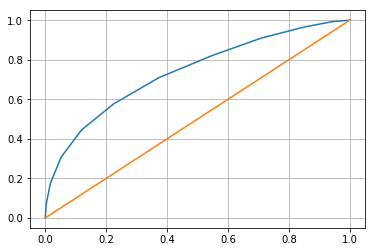

In [106]:
score_dataset(dataset, non_sq_cols)

# XGBoost

In [118]:
drop_cols = ['y', 'Timestamp', 'IncidentID'] #, 'Longitude', 'Latitude']
tr_X, te_X, tr_y, te_y = train_test_split(dataset.drop(columns=drop_cols), dataset['y'], stratify=dataset.y, test_size=.2)
scaler = StandardScaler()
tr_X = scaler.fit_transform(tr_X)
te_X = scaler.transform(te_X)
tr_d = xgb.DMatrix(tr_X, label=tr_y)
te_d = xgb.DMatrix(te_X, label=te_y)

In [218]:
xgb_params = {'objective':'binary:logistic', 'learning_rate': 1.0, 'n_estimators': 500}

In [222]:
clf = xgb.XGBClassifier(**xgb_params)

In [223]:
clf.fit(tr_X, tr_y)

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=1.0, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=500, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)

In [224]:
prd = clf.predict(te_X)

/opt/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [219]:
prd = np.round(prd)

f1_score(te_y, prd)

/opt/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


0.8229463511336885

In [220]:
def boost(dataset, drop_features=[], cv=5):
    drop_cols = ['y', 'Timestamp', 'IncidentID'] + drop_features #, 'Longitude', 'Latitude'
    tr_X, te_X, tr_y, te_y = train_test_split(dataset.drop(columns=drop_cols), dataset['y'], stratify=dataset.y, test_size=.2)
    scaler = StandardScaler()
    tr_X = scaler.fit_transform(tr_X)
    te_X = scaler.transform(te_X)
        
    print('XGBoost')
    xgb_params = {'objective':'binary:logistic', 'learning_rate': 1.0, 'n_estimators': 500}
    clf = xgb.XGBClassifier(**xgb_params)
    cv_res = cross_validate(clf, tr_X, tr_y, n_jobs=-1, cv=cv, scoring={'f1_score' : make_scorer(f1_score)})
    F1_score = cv_res['test_f1_score'].mean()
    F1_var = cv_res['test_f1_score'].std()
    print('{}-fold CV f1 = {}, std = {}'.format(cv, F1_score, F1_var))
    clf.fit(tr_X, tr_y)
    predict = clf.predict(te_X)
    print('example CM =', confusion_matrix(te_y, predict))
    proba = clf.predict_proba(te_X)
    fpr, tpr, thresholds = roc_curve(te_y, proba[:,1])
    print()
      
    plt.plot(fpr, tpr)
    plt.plot([0,1], [0,1])
    plt.grid()
    plt.show()
    
    print()
    


XGBoost


/opt/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/opt/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/opt/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/opt/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but i

5-fold CV f1 = 0.790687483003813, std = 0.0072935016643392945


/opt/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


example CM = [[3810  687]
 [ 756 3326]]



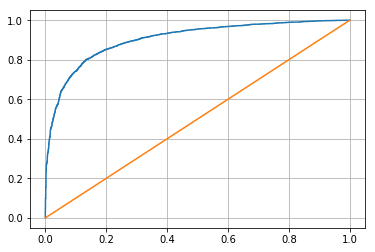

In [221]:
boost(dataset)